In [323]:
import numpy as np
# a
def get_sample(n=500, m1=5, s1=np.sqrt(2)):
    index = np.random.binomial(1, .3, size=n)
    x = np.zeros(shape=(n,))
    x[index==1] = np.random.normal(1, 1, size=np.sum((index==1)))
    x[index==0] = np.random.normal(m1, s1, size=n - np.sum((index==1)))
    return x, -1 * (index - 1)

get_sample(n=500)[0]

array([ 1.46987369,  5.86914459,  7.87708385,  5.77358798,  1.59346024,
        0.46515052,  0.89102474,  3.8604599 ,  7.2756646 ,  2.58730415,
        5.16064114,  3.51315919,  4.6101466 ,  5.46425936,  7.24793296,
        4.72900308,  1.00665124, -0.62407235,  6.21368774,  6.33816963,
        4.84487869,  1.88554456,  2.07807928,  7.09445218,  3.79210534,
        1.27307331,  1.55090713,  4.21552075,  7.35535152,  0.66070023,
        0.25088016,  6.20220651,  0.42988649,  7.38788798,  2.74714685,
       -0.35169677,  6.14763367,  4.16100855,  4.48236095,  7.85291119,
        8.23364696,  4.80505486, -0.15674621,  6.73433965,  5.68659019,
        5.44165869,  3.18820288,  5.74608135,  1.50409829,  4.21766771,
        3.22393098,  4.26500418,  5.14881755,  2.60065423,  1.33521641,
        6.5384014 ,  1.34257508,  6.85594261,  3.5702096 ,  2.36318698,
        2.87494539,  4.9285468 ,  4.14126865, -1.0393903 ,  6.39836028,
        1.91735314,  1.68423613,  2.50326539,  4.5445753 ,  2.97

<Axes: ylabel='Count'>

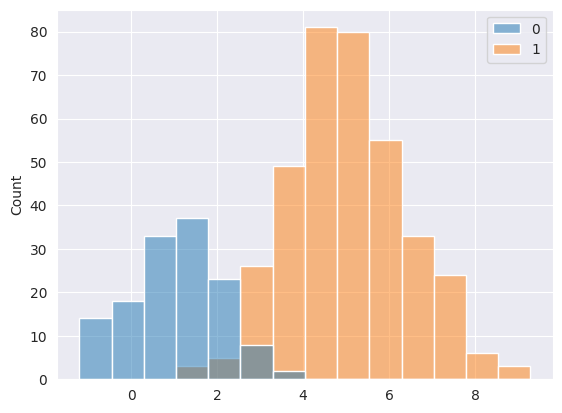

In [324]:
import seaborn as sns
x, g = get_sample(n=500)
sns.histplot(x=x, hue=g)

<Axes: ylabel='Count'>

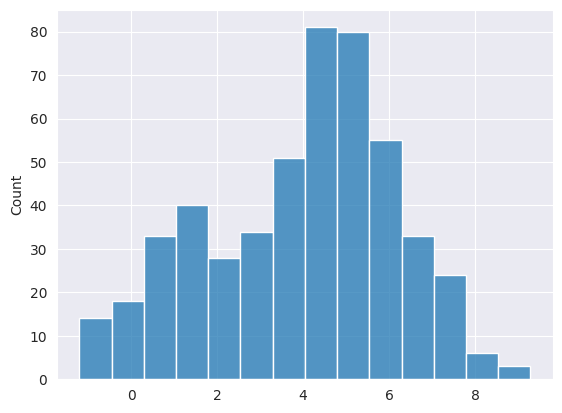

In [325]:
sns.histplot(x=x)

In [38]:
# b
from scipy import stats

def loglik(x, g):
    return np.sum(
        np.log(
            (g==0) * stats.norm(loc=1, scale=1).pdf(x) * .3
            + (g==1) * stats.norm(loc=5, scale=2).pdf(x) * .7
        )
    )

loglik(x, g)

-1162.901212847979

In [39]:
# c E step
# p(g|x,theta) = p(g,x|theta)/p(x|theta)
# p(g,x|theta) = p(x|g,theta)p(g|theta)
def e_step(x, pi0, pi1, m0, m1, s0, s1):
    return pi1 * stats.norm(m1, s1).pdf(x) / (
            pi0 * stats.norm(m0, s0).pdf(x) 
            + pi1 * stats.norm(m1, s1).pdf(x)
    )

In [40]:
# d M step

def m_step(x, gamma):
    m0 = np.sum((1-gamma)*x)/np.sum((1-gamma))
    m1 = np.sum(gamma * x)/np.sum(gamma)
    s0 = np.sqrt(np.sum((1-gamma)*(x-m0)**2)/np.sum(1-gamma))
    s1 = np.sqrt(np.sum(gamma * (x - m1)**2)/np.sum(gamma))
    pi0 = np.mean(gamma)
    pi1 = np.mean(1-gamma)
    return pi0, pi1, m0, m1, s0, s1



In [317]:
# e

def emp_loglik(x, gamma, pi0, pi1, m0, m1, s0, s1):
    return np.sum(
            gamma * (np.log(stats.norm(loc=m0, scale=s0).pdf(x) * pi0))
            + (1-gamma) * (np.log(stats.norm(loc=m1, scale=s1).pdf(x) * pi1))
    )


def em_algorithm(x):
    pi0 = pi1 = 1/2
    s0 = s1 = np.std(x)
    m0 = x[np.random.choice(len(x), size=1)]
    m1 = x[np.random.choice(len(x), size=1)]
    old_loglik = None
    loglik = None
    iter = 0
    while not old_loglik or (loglik and abs(old_loglik - loglik) >= 1e-10):
        iter+=1
        old_loglik = loglik
        gamma = e_step(x, pi0, pi1, m0, m1, s0, s1)
        pi0, pi1, m0, m1, s0, s1 = m_step(x, gamma)
        loglik = emp_loglik(x, gamma, pi0, pi1, m0, m1, s0, s1)
    return pi0, m0, m1, s0, s1, iter
x, g = get_sample(5000, m1=5, s1=np.sqrt(2))
pi0, m0, m1, s0, s1, iter = em_algorithm(x)
print(iter)
print(pi0, m0, s0**2, m1, s1**2)

118
0.4872248551872117 5.504773604120452 1.3793320978923738 2.105727742360653 2.9456357643206834


<Axes: ylabel='Density'>

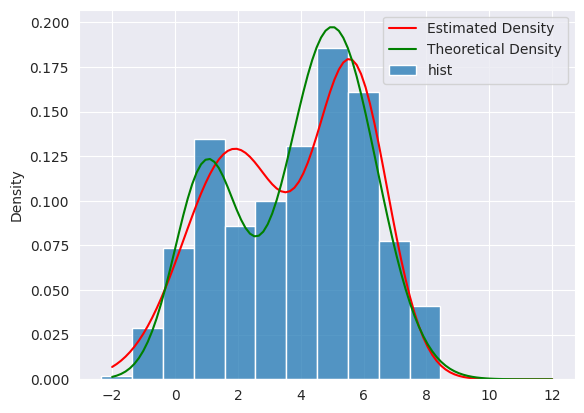

In [338]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()



def estimated_density(x, pi0, pi1, m0, m1, s0, s1):
    return pi0 * stats.norm(m0, s0).pdf(x) + pi1 *( stats.norm(m1, s1).pdf(x))

def theoretical_density(x):
    return .3 * stats.norm(loc=1, scale=1).pdf(x) + .7 * stats.norm(loc=5, scale=np.sqrt(2)).pdf(x)

x, g = get_sample()

sns.histplot(x, ax=ax, label="hist", stat="density")
pi0, m0, m1, s0, s1, it = em_algorithm(x)
x_vals = np.linspace(-2, 12, 100)
sns.lineplot(x=x_vals, y=estimated_density(x_vals, pi0, 1-pi0,  m0, m1, s0, s1), ax=ax, label='Estimated Density', color="red")

sns.lineplot(x=x_vals, y=theoretical_density(x_vals), label="Theoretical Density", color="green")